In [2]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from flow import Planar

In [3]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cpu')

In [4]:
class PriorDistribution:
    def __init__(self):
        raise NotImplementedError

    def log_prob(self, z):
        """
        :param z: value or batch of latent variable
        :return: log probability of the distribution for z
        """
        raise NotImplementedError

class TwoModes(PriorDistribution):
    def __init__(self, loc, scale):
        """
        Distribution 2d with two modes at z[0] = -loc and z[0] = loc
        :param loc: distance of modes from the origin
        :param scale: scale of modes
        """
        self.loc = loc
        self.scale = scale

    def log_prob(self, z):
        """
        log(p) = 1/2 * ((norm(z) - loc) / (2 * scale)) ** 2
                - log(exp(-1/2 * ((z[0] - loc) / (3 * scale)) ** 2) + exp(-1/2 * ((z[0] + loc) / (3 * scale)) ** 2))
        :param z: value or batch of latent variable
        :return: log probability of the distribution for z
        """
        a = torch.abs(z[:, 0])
        eps = torch.abs(torch.tensor(self.loc))

        log_prob = - 0.5 * ((torch.norm(z, dim=1) - self.loc) / (2 * self.scale)) ** 2 \
                   - 0.5 * ((a - eps) / (3 * self.scale)) ** 2 \
                   + torch.log(1 + torch.exp(-2 * (a * eps) / (3 * self.scale) ** 2))

        return log_prob

class BaseDistribution(nn.Module):
    """
    Base distribution of a flow-based model
    Parameters do not depend of target variable (as is the case for a VAE encoder)
    """
    def __init__(self):
        super().__init__()

    def forward(self, num_samples=1):
        """
        Samples from base distribution and calculates log probability
        :param num_samples: Number of samples to draw from the distriubtion
        :return: Samples drawn from the distribution, log probability
        """
        raise NotImplementedError

    def log_prob(self, z):
        """
        Calculate log probability of batch of samples
        :param z: Batch of random variables to determine log probability for
        :return: log probability for each batch element
        """
        raise NotImplementedError
        
class DiagGaussian(BaseDistribution):
    """
    Multivariate Gaussian distribution with diagonal covariance matrix
    """
    def __init__(self, shape, trainable=True):
        """
        Constructor
        :param shape: Tuple with shape of data, if int shape has one dimension
        """
        super().__init__()
        if isinstance(shape, int):
            shape = (shape,)
        self.shape = shape
        self.n_dim = len(shape)
        self.d = np.prod(shape)
        if trainable:
            self.loc = nn.Parameter(torch.zeros(1, *self.shape))
            self.log_scale = nn.Parameter(torch.zeros(1, *self.shape))
        else:
            self.register_buffer("loc", torch.zeros(1, *self.shape))
            self.register_buffer("log_scale", torch.zeros(1, *self.shape))
        self.temperature = None  # Temperature parameter for annealed sampling

    def forward(self, num_samples=1):
        eps = torch.randn((num_samples,) + self.shape, dtype=self.loc.dtype,
                          device=self.loc.device)
        if self.temperature is None:
            log_scale = self.log_scale
        else:
            log_scale = self.log_scale + np.log(self.temperature)
        z = self.loc + torch.exp(log_scale) * eps
        log_p = - 0.5 * self.d * np.log(2 * np.pi) \
                - torch.sum(log_scale + 0.5 * torch.pow(eps, 2), list(range(1, self.n_dim + 1)))
        return z, log_p

    def log_prob(self, z):
        if self.temperature is None:
            log_scale = self.log_scale
        else:
            log_scale = self.log_scale + np.log(self.temperature)
        log_p = - 0.5 * self.d * np.log(2 * np.pi)\
                - torch.sum(log_scale + 0.5 * torch.pow((z - self.loc) / torch.exp(log_scale), 2),
                            list(range(1, self.n_dim + 1)))
        return log_p



In [5]:
class NormalizingFlow(nn.Module):
    """
    Normalizing Flow model to approximate target distribution
    """
    def __init__(self, q0, flows, p=None):
        """
        Constructor
        :param q0: Base distribution
        :param flows: List of flows
        :param p: Target distribution
        """
        super().__init__()
        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def forward_kld(self, x):
        """
        Estimates forward KL divergence, see arXiv 1912.02762
        :param x: Batch sampled from target distribution
        :return: Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)

    def reverse_kld(self, num_samples=1, beta=1., score_fn=True):
        """
        Estimates reverse KL divergence, see arXiv 1912.02762
        :param num_samples: Number of samples to draw from base distribution
        :param beta: Annealing parameter, see arXiv 1505.05770
        :param score_fn: Flag whether to include score function in gradient, see
        arXiv 1703.09194
        :return: Estimate of the reverse KL divergence averaged over latent samples
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        if not score_fn:
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)
            utils.set_requires_grad(self, False)
            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)
            utils.set_requires_grad(self, True)
        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)

    def reverse_alpha_div(self, num_samples=1, alpha=1, dreg=False):
        """
        Alpha divergence when sampling from q
        :param num_samples: Number of samples to draw
        :param dreg: Flag whether to use Double Reparametrized Gradient estimator,
        see arXiv 1810.04152
        :return: Alpha divergence
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        log_p = self.p.log_prob(z)
        if dreg:
            w_const = torch.exp(log_p - log_q).detach()
            z_ = z
            log_q = torch.zeros(len(z_), device=z_.device)
            utils.set_requires_grad(self, False)
            for i in range(len(self.flows) - 1, -1, -1):
                z_, log_det = self.flows[i].inverse(z_)
                log_q += log_det
            log_q += self.q0.log_prob(z_)
            utils.set_requires_grad(self, True)
            w = torch.exp(log_p - log_q)
            w_alpha = w_const ** alpha
            w_alpha = w_alpha / torch.mean(w_alpha)
            weights = (1 - alpha) * w_alpha + alpha * w_alpha ** 2
            loss = -alpha * torch.mean(weights * torch.log(w))
        else:
            loss = -torch.logsumexp(alpha * (log_p - log_q), 0) + \
                math.log(log_p.shape[0])
        return loss

    def sample(self, num_samples=1):
        """
        Samples from flow-based approximate distribution
        :param num_samples: Number of samples to draw
        :return: Samples, log probability
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q

    def log_prob(self, x):
        """
        Get log probability for batch
        :param x: Batch
        :return: log probability
        """
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q

    def save(self, path):
        """
        Save state dict of model
        :param path: Path including filename where to save model
        """
        torch.save(self.state_dict(), path)

    def load(self, path):
        """
        Load model from state dict
        :param path: Path including filename where to load model from
        """
        self.load_state_dict(torch.load(path))

In [25]:
n_flows = 16
flows = []

for i in range(n_flows):
    flows += [Planar((2,))]
target = TwoModes(2, 0.1)
q0 = DiagGaussian(2)

In [28]:
nfm = NormalizingFlow(q0=q0, flows = flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
    (10): Planar()
    (11): Planar()
    (12): Planar()
    (13): Planar()
    (14): Planar()
    (15): Planar()
  )
)

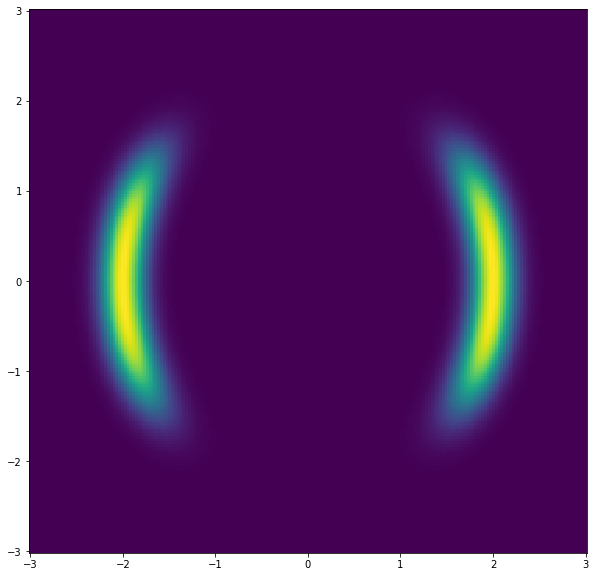

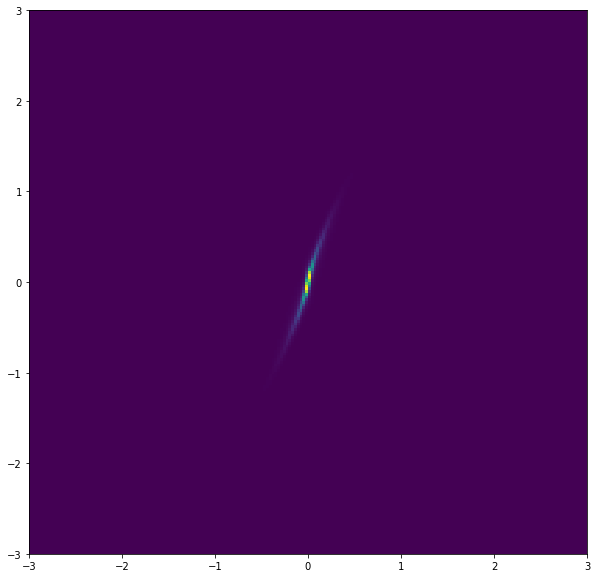

In [29]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

 10%|▉         | 1999/20000 [00:38<05:26, 55.14it/s]

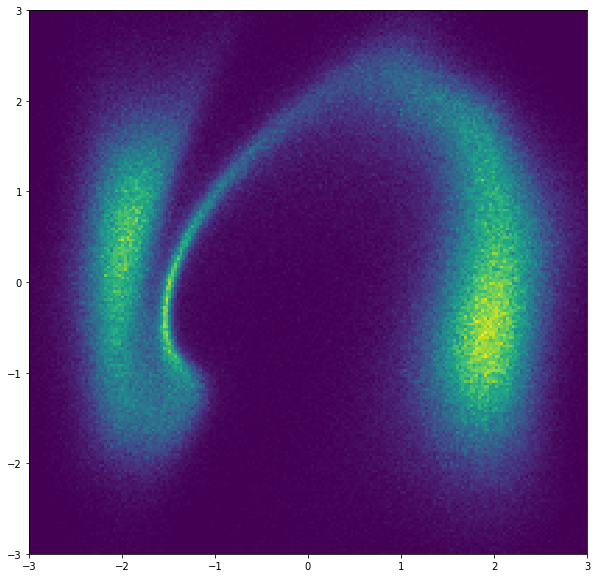

 20%|█▉        | 3996/20000 [01:25<04:39, 57.35it/s]

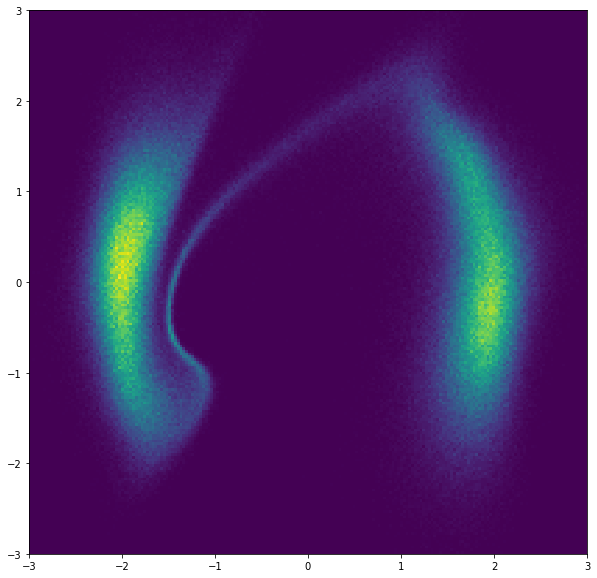

 30%|██▉       | 5996/20000 [02:05<07:14, 32.24it/s]

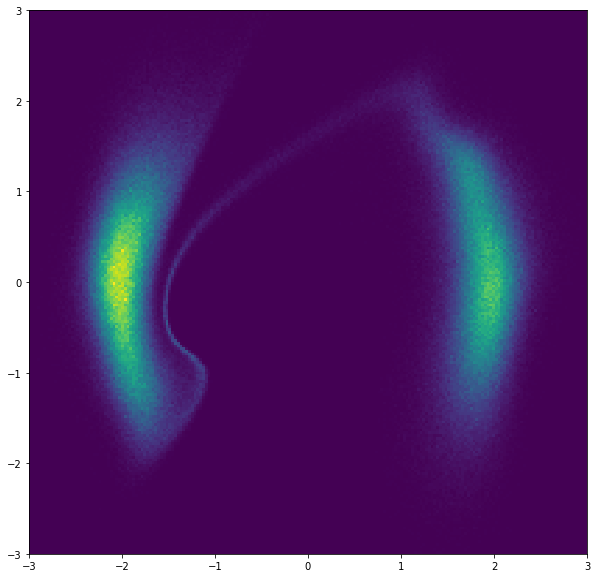

 40%|███▉      | 7996/20000 [02:51<03:18, 60.51it/s]

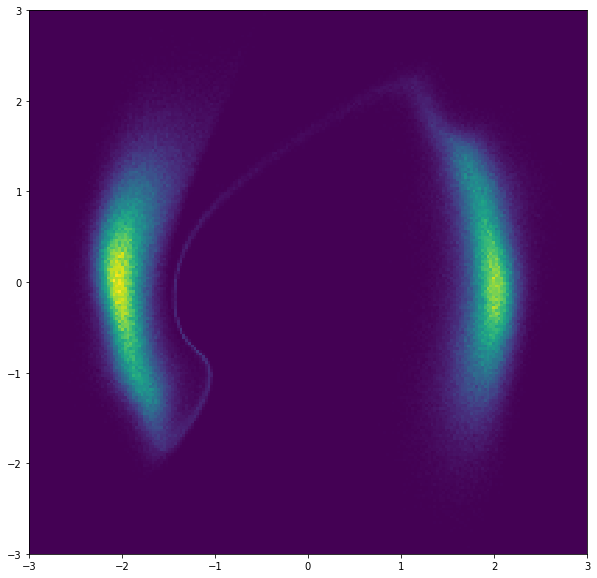

 50%|████▉     | 9997/20000 [03:28<02:43, 61.03it/s]

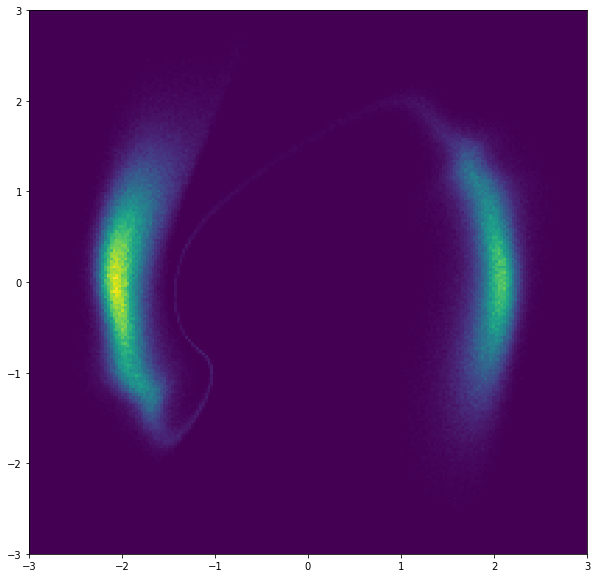

 60%|█████▉    | 11998/20000 [04:09<03:19, 40.21it/s]

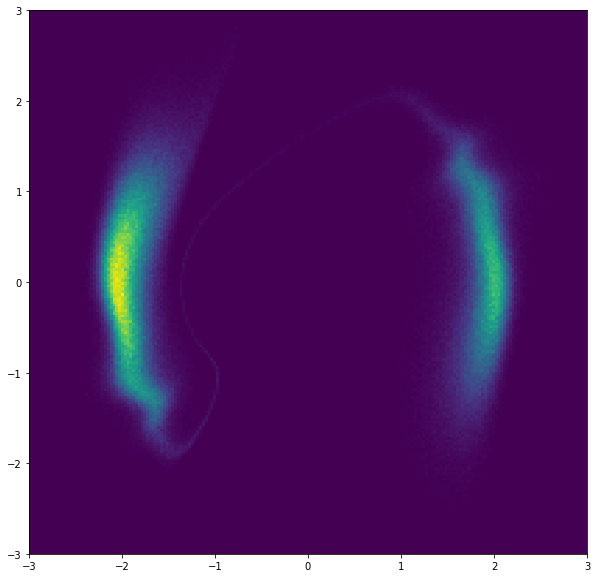

 70%|██████▉   | 13999/20000 [04:46<01:59, 50.33it/s]

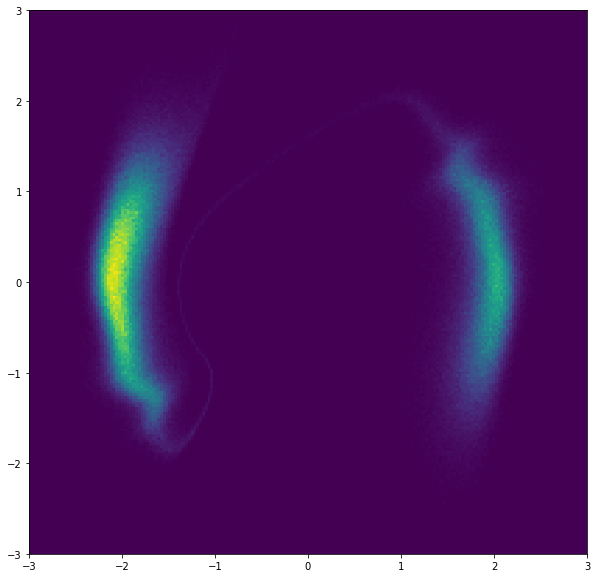

 80%|███████▉  | 15997/20000 [05:30<01:43, 38.75it/s]

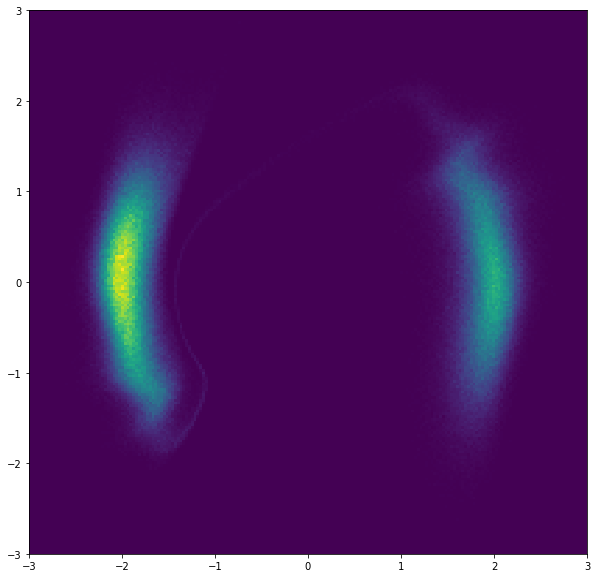

 90%|████████▉ | 17996/20000 [06:11<00:33, 60.37it/s]

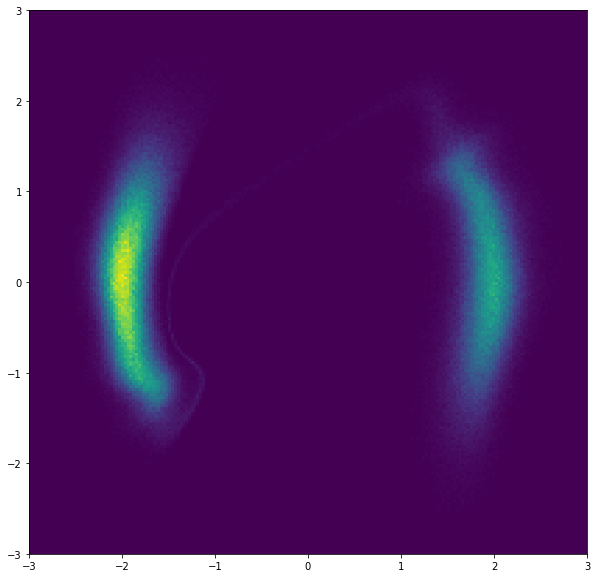

100%|█████████▉| 19997/20000 [06:51<00:00, 46.36it/s]

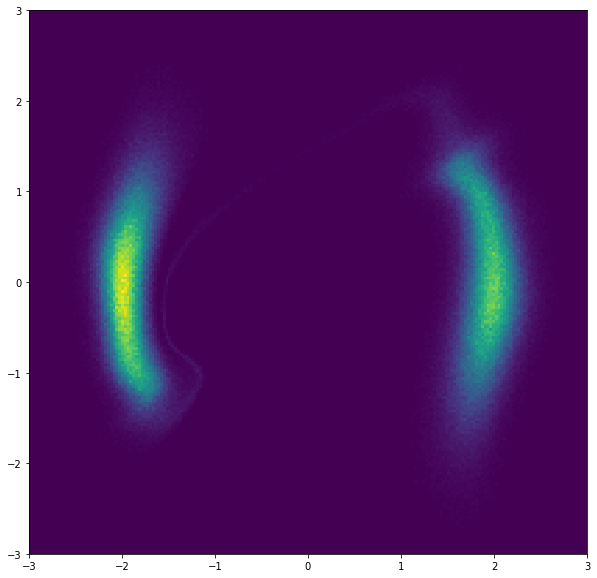

100%|██████████| 20000/20000 [06:54<00:00, 48.26it/s]


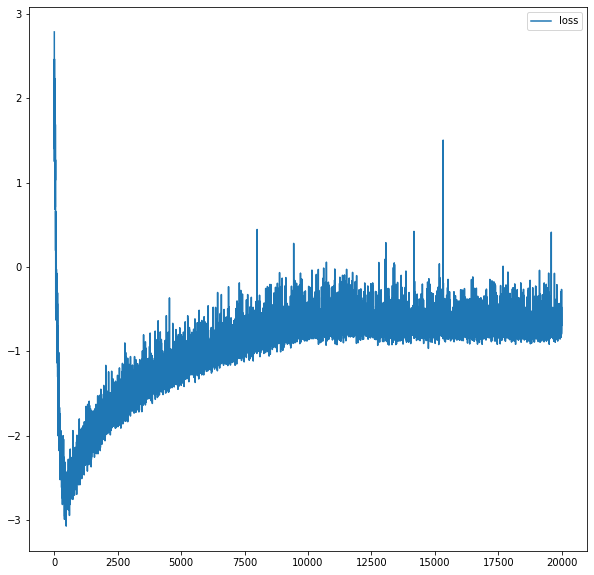

In [10]:
# Train model
max_iter = 20000
num_samples = 2 * 20
anneal_iter = 10000
annealing = True
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = nfm.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        torch.cuda.manual_seed(0)
        z, _ = nfm.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()
        
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

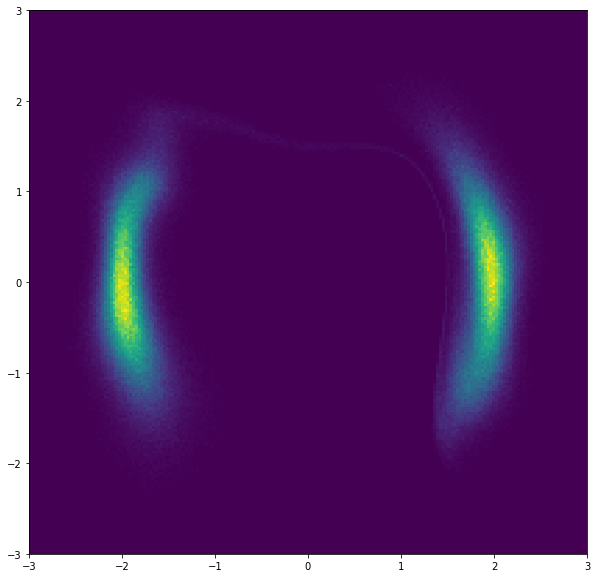

In [ ]:
# Plot learned posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [46]:
from vae_re import VAEReferenceEncoder

In [47]:
m = VAEReferenceEncoder(80, 128, 128)

In [48]:
inp = torch.rand((32,100,80))

In [56]:
m(inp)[0].size()

torch.Size([32, 128])